In [1]:
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os

import cv2
from natsort import natsorted
from skimage.registration import phase_cross_correlation

from skimage.transform import warp
from scipy import ndimage as scp
from tqdm import tqdm
%matplotlib inline
from statsmodels.tsa.stattools import acf
import numpy as np

import pickle
from scipy.fftpack import fft2, fftshift, ifft2, fft
# from matplotlib.colors import hsv_to_rgb
from skimage.color import hsv2rgb as h2r

In [2]:
import ants.registration as ants_register
import ants
import scipy.optimize as optz
from itertools import permutations 
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.metrics.pairwise import manhattan_distances
from skimage.filters import threshold_otsu

In [667]:
# with open('pickles/data_pics_sc1.pickle', 'rb') as handle:
#     data_sc1 = pickle.load(handle)

In [3]:
path = '2D/2D_timelapse_postsolution/scan1/pic/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = natsorted(pic_paths)[:1000]

pics_without_line = []


for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    # pics_with_line.append(aa.copy())
    point = np.argmax(np.sum(aa[:500],axis=1))
    aa[point-30:point+50]=0 #aa[0:80]
    aa[800:]=0
    pics_without_line.append(aa.copy())


100%|██████████| 1000/1000 [00:01<00:00, 595.88it/s]


In [4]:
data_sc1 = np.array(pics_without_line)
data_sc1 = data_sc1[range(0,data_sc1.shape[0],2)]

In [5]:
rand_range = [250]
for _ in rand_range:
    for i in tqdm(range(len(data_sc1))):
        coords = phase_cross_correlation(data_sc1[_],data_sc1[i],normalization=None)[0]
        # data_sc1[i] = scp.shift(data_sc1[i],shift = (int(coords[0]),int(coords[1])),mode='nearest',order=0)
        data_sc1[i] = scp.shift(data_sc1[i],shift = (coords[0],coords[1]),mode='constant',order=3)



100%|██████████| 500/500 [00:51<00:00,  9.63it/s]


In [9]:
# back_removed_trial = []
# for img_remove_back in tqdm(back_removed):
#     aa = img_remove_back.copy()
#     thresh = threshold_otsu(aa)
#     aa[aa<=thresh] = 0
#     back_removed_trial.append(aa)
# back_removed_trial = np.array(back_removed_trial)
back_removed_trial = back_removed[:50].copy()

In [10]:
def ants_reg(stat,mov):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Affine')
    reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg_img.numpy()

In [11]:
manual_regs_trial = []
for i in tqdm(range(0,back_removed_trial.shape[0])):
    regis = ants_reg(back_removed_trial[10],back_removed_trial[i])
    manual_regs_trial.append(regis)
manual_regs_trial = np.array(manual_regs_trial)

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


In [1232]:
# from skimage.metrics import normalized_mutual_information as nmi
# from skimage.metrics import hausdorff_distance as mse
# from skimage.metrics import structural_similarity as ss

In [1233]:
# c = list(itertools.product(range(-2,5), range(-2,5)))

In [1234]:
# def shift_nmi(shift,img_stat,img_mov):
#     shifted = scp.shift(img_mov,shift=(shift[0],shift[1]),mode='constant',cval=0)
#     return -nmi(img_stat,shifted)

In [1235]:
# mm=[]
# for k in c:
#     mm.append(shift_nmi(k,data_sc1[2],data_sc1[3]))

In [1236]:
# plt.plot(mm)
# plt.xticks(ticks = range(0,len(c)),labels=c,rotation=90)
# plt.show()

In [1237]:
# g = optz.minimize(shift_nmi,x0=(-1,5),method='powell',args=(data_sc1[2],data_sc1[3]))
# g['x']

In [1238]:
# from dipy.align.transforms import (TranslationTransform2D,
#                                    RigidTransform2D,
#                                    AffineTransform2D)
# from dipy.align.imaffine import AffineRegistration

# affreg = AffineRegistration(sigmas = [1,0],level_iters=[10,10],factors=[2,1],verbosity=0)
# transform = TranslationTransform2D()

# def aff_reg(static,moving):
#     affine = affreg.optimize(static, moving, transform, params0=None);
#     regss = affine.transform(moving);
#     return regss;

# stat = data_sc1[250]
# registered_aff = []
# for i in tqdm(range(0,len(data_sc1),20)):
#     registered_aff.append(aff_reg(stat,data_sc1[i]));


In [1239]:
# for i,j in tqdm(enumerate(manual_regs_trial)):
#     cv2.imwrite('2D/2D_timelapse_postsolution/test/'+f'frame_trial{i}.PNG',j.astype(np.uint16))

In [12]:
def ants_reg_transfrom(stat,mov):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Affine')
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']

In [13]:
new_trans = ants_reg_transfrom(back_removed[55],manual_regs_trial[-1])

In [14]:
def apply_trans_ants(stat,mov,trans):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    # reg = ants_register(ants2,ants1,type_of_transform = 'Affine')
    reg_img = ants.apply_transforms(ants2, ants1, trans)
    return reg_img.numpy()

In [15]:
first_50 = []
for i in range(50):
    reg_img = apply_trans_ants(back_removed[55],manual_regs_trial[i],new_trans)
    first_50.append(reg_img)

new_merge_trail = back_removed.copy()
new_merge_trail[:50] = np.array(first_50)

In [16]:
# back_removed_merged = []
# for img_remove_back in tqdm(new_merge_trail):
#     aa = img_remove_back.copy()
#     thresh = threshold_otsu(aa)
#     aa[aa<=thresh] = 0
#     back_removed_merged.append(aa)
back_removed_merged = np.array(new_merge_trail)

In [1281]:
for i,j in tqdm(enumerate(manual_regs_sc2)):
    cv2.imwrite('2D/2D_timelapse_postsolution/test/'+f'frame_trial{i}.PNG',j.astype(np.uint16))

500it [00:01, 276.13it/s]


In [6]:
def ants_reg(stat,mov):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Translation')
    reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg_img.numpy()

In [7]:
manual_regs = []
for i in tqdm(range(0,data_sc1.shape[0])):
    regis = ants_reg(data_sc1[250],data_sc1[i])
    manual_regs.append(regis)
manual_regs = np.array(manual_regs)

100%|██████████| 500/500 [05:03<00:00,  1.65it/s]


In [8]:
# back_removed = []
# for img_remove_back in tqdm(manual_regs):
#     aa = img_remove_back.copy()
#     thresh = threshold_otsu(aa)
#     aa[aa<=thresh] = 0
#     back_removed.append(aa)
back_removed = np.array(manual_regs)

In [1227]:
# os.mkdir('2D/2D_timelapse_postsolution/registered/scan1/tif/')
for i,j in tqdm(enumerate(back_removed)):
    cv2.imwrite('2D/2D_timelapse_postsolution/registered/scan1/'+f'frame_ants{i}.PNG',j.astype(np.uint16))

500it [00:03, 165.37it/s]


In [1056]:
with open('pickles/ANTS_sc1_50.pickle', 'wb') as handle:
    pickle.dump(manual_regs_trial, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('pickles/ANTS_sc1_merged.pickle', 'wb') as handle:
    pickle.dump(back_removed_merged, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Scan2

In [ ]:
# with open('pickles/data_pics_sc2.pickle', 'rb') as handle:
#     data_sc1 = pickle.load(handle)

In [1300]:
path = '2D/2D_timelapse_postsolution/scan2/pic/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = natsorted(pic_paths)[:1000]

pics_without_line = []
pics_with_line = []


for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    aa[800:]=0
    pics_with_line.append(aa.copy())
    point = np.argmax(np.sum(aa[:500],axis=1))
    aa[point-30:point+50]=0
    aa[800:]=0
    pics_without_line.append(aa.copy())


100%|██████████| 1000/1000 [00:02<00:00, 381.10it/s]


In [1301]:
data_sc2 = np.array(pics_without_line)
data_sc2 = data_sc2[range(0,data_sc2.shape[0],2)]

In [1302]:
rand_range = [250]
for _ in rand_range:
    for i in tqdm(range(len(data_sc2))):
        coords = phase_cross_correlation(data_sc2[_],data_sc2[i],normalization=None)[0]
        data_sc2[i] = scp.shift(data_sc2[i],shift = (coords[0],coords[1]),mode='constant',order=3)
        # data_sc2_line[i] = scp.shift(data_sc2_line[i],shift = (int(coords[0]),int(coords[1])),mode='nearest',order=0)


100%|██████████| 500/500 [00:44<00:00, 11.30it/s]


In [1303]:
def ants_reg(stat,mov):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Affine')
    reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg_img.numpy()

In [1304]:
manual_regs_sc2 = []
for i in tqdm(range(0,data_sc2.shape[0])):
    regis = ants_reg(data_sc2[250],data_sc2[i])
    manual_regs_sc2.append(regis)
manual_regs_sc2 = np.array(manual_regs_sc2)

100%|██████████| 500/500 [06:19<00:00,  1.32it/s]


In [1306]:
for i,j in tqdm(enumerate(manual_regs_sc2)):
    cv2.imwrite('2D/2D_timelapse_postsolution/test/'+f'frame_trial{i}.PNG',j.astype(np.uint16))

500it [00:02, 175.18it/s]


In [1307]:
half_sc2 = manual_regs_sc2[:100].copy()

In [1308]:
half_sc2_trial = []
for i in tqdm(range(0,half_sc2.shape[0])):
    regis = ants_reg(half_sc2[10],half_sc2[i])
    half_sc2_trial.append(regis)
half_sc2_trial = np.array(half_sc2_trial)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [ ]:
def ants_reg_transfrom(stat,mov):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Affine')
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']

In [1310]:
half_sc2_trans = ants_reg_transfrom(manual_regs_sc2[102],half_sc2_trial[-1])

In [1311]:
half_sc2_100 = []
for i in range(100):
    reg_img = apply_trans_ants(manual_regs_sc2[102],half_sc2_trial[i],half_sc2_trans)
    half_sc2_100.append(reg_img)

new_merge_trail_sc2 = manual_regs_sc2.copy()
new_merge_trail_sc2[:100] = np.array(half_sc2_100)

In [1313]:
# manual_regs_sc2_line = []
# for i in tqdm(range(0,data_sc2.shape[0])):
#     regis = ants_reg(data_sc2[250],data_sc2[i])
#     manual_regs_sc2_line.append(regis)
# manual_regs_sc2_line = np.array(manual_regs_sc2_line)

# back_removed_sc2_line = []
# for img_remove_back in tqdm(manual_regs_sc2_line):
#     aa = img_remove_back.copy()
#     thresh = threshold_otsu(aa)
#     aa[aa<=thresh] = 0
#     back_removed_sc2_line.append(aa)
# back_removed_sc2_line = np.array(back_removed_sc2_line)

In [1314]:
back_removed_sc2 = []
for img_remove_back in tqdm(new_merge_trail_sc2):
    aa = img_remove_back.copy()
    thresh = threshold_otsu(aa)
    aa[aa<=thresh] = 0
    back_removed_sc2.append(aa)
back_removed_sc2 = np.array(back_removed_sc2)

100%|██████████| 500/500 [00:02<00:00, 195.74it/s]


In [1315]:
# os.mkdir('2D/2D_timelapse_postsolution/registered/scan2/')
for i,j in tqdm(enumerate(back_removed_sc2)):
    cv2.imwrite('2D/2D_timelapse_postsolution/registered/scan2/'+f'frame_ants{i}.PNG',j.astype(np.uint16))

500it [00:02, 211.25it/s]


In [1317]:
with open('pickles/ANTS_sc2_merged.pickle', 'wb') as handle:
    pickle.dump(back_removed_sc2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1076]:
with open('pickles/ANTS_sc2_100.pickle', 'wb') as handle:
    pickle.dump(manual_regs_sc2_trial, handle, protocol=pickle.HIGHEST_PROTOCOL)

# P2s model training

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [89]:
manual_regs[252,482:485,162:165]

array([[114,  33,  61],
       [125,  30,  57],
       [114,  35,  38]], dtype=uint8)

In [90]:
train_data = np.concatenate((manual_regs[250:252,482:485,162:165],manual_regs[253:255,482:485,162:165]))
test_data = manual_regs[252,482:485,162:165].copy()

In [93]:
train_data = train_data.reshape(4,9)
test_data = test_data.ravel().reshape(1,-1)

In [94]:
train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)

In [95]:
test_data.shape

(1, 9)

In [102]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [137]:
mlp = MLPRegressor(random_state=11, max_iter=10000)

In [138]:
reg = mlp.fit(train_data.T,test_data.T.ravel())

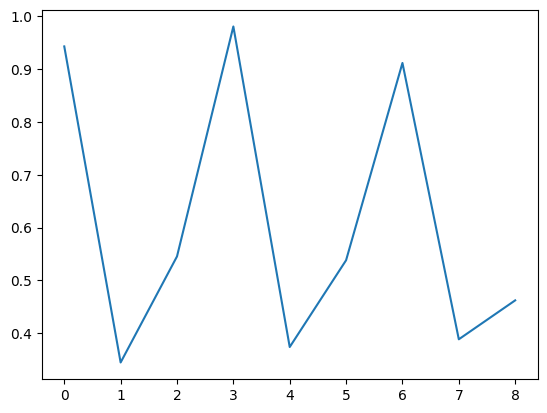

In [140]:
plt.plot(reg.predict(train_data.T))

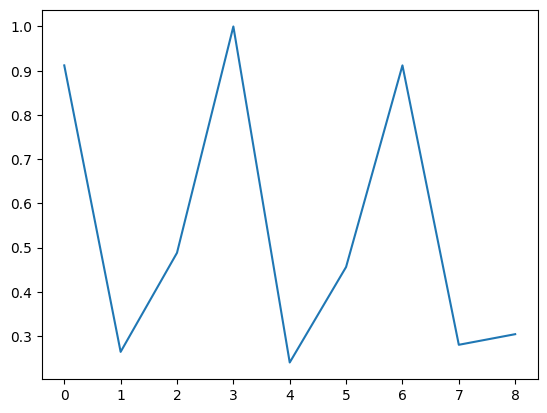

In [141]:
plt.plot(test_data.ravel())

In [422]:
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,denoise_tv_bregman,
                                 denoise_wavelet, estimate_sigma,calibrate_denoiser)

In [179]:
sigma_est = np.mean(estimate_sigma(manual_regs[252], channel_axis=-1))

In [ ]:
# # import os
# # os.mkdir('2D/2D_timelapse_postsolution/test/')
# for i,j in tqdm(enumerate(manual_seq)):
#     cv2.imwrite('2D/2D_timelapse_postsolution/test/'+f'frame{i}.PNG',j.astype(np.uint16))

In [616]:
noisy = manual_regs[252].copy()

In [474]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error as mse
from skimage.restoration import denoise_invariant


In [454]:
patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=2,  # 13x13 search area
                )

# slow algorithm
denoise = denoise_nl_means(noisy, h=0.1 * sigma_est,sigma =sigma_est,  fast_mode=True,
                           **patch_kw)

In [609]:
denoise = denoise_wavelet(noisy,rescale_sigma=False,method='VisuShrink')
# denoise = denoise_bilateral(noisy)

In [603]:
parameter_ranges = {'rescale_sigma':['True','False'],'wavelet': ['db1', 'db2','sym9'],
                'method':['VisuShrink','BayesShrink'],'mode':['soft', 'hard'],'sigma':[0.0175]
                }

In [604]:
calibrated_denoiser = calibrate_denoiser(noisy,
                                         denoise_wavelet,
                                         denoise_parameters=parameter_ranges
                                         )

In [605]:
calibrated_denoiser

functools.partial(<function denoise_invariant at 0x1ea144540>, denoise_function=<function denoise_wavelet at 0x175723f60>, stride=4, denoiser_kwargs={'rescale_sigma': 'True', 'wavelet': 'sym9', 'method': 'BayesShrink', 'mode': 'hard', 'sigma': 0.0175})

In [606]:
calibrated_output = calibrated_denoiser(noisy)

In [ ]:
denoiser_kwargs={'rescale_sigma': 'True', 'wavelet': 'db2', 'method': 'BayesShrink', 'mode': 'soft'}

In [611]:
sigma = 0.012
sigma_range = np.arange(sigma/2, 2*sigma, 0.001)
parameters_tested = [{'rescale_sigma': 'True', 'wavelet': 'db2', 'method': 'BayesShrink', 'mode': 'soft','sigma':sigma}
                     for sigma in sigma_range]

denoised_invariant = [denoise_invariant(noisy, denoise_wavelet,
                                        denoiser_kwargs=params)
                      for params in parameters_tested]

In [612]:
sigma_range

array([0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014,
       0.015, 0.016, 0.017, 0.018, 0.019, 0.02 , 0.021, 0.022, 0.023])

In [613]:
self_supervised_loss = [mse(img, noisy) for img in denoised_invariant]

In [614]:
self_supervised_loss

[162.14374512600102,
 162.14254406038737,
 162.14097519449672,
 162.13892620915163,
 162.13625654571007,
 162.13272660966103,
 162.12796547822288,
 162.1217646144458,
 162.11535046298417,
 162.10884435179548,
 162.1050944302177,
 162.1015626074025,
 162.10123114481925,
 162.1050041517547,
 162.10914282597727,
 162.1136711849693,
 162.1186372618948,
 162.12410988692844]

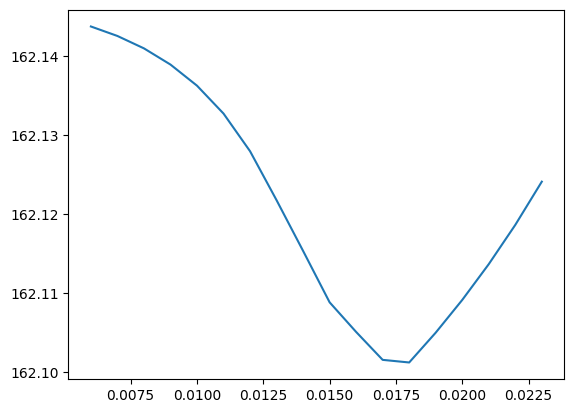

In [615]:
plt.plot(sigma_range, self_supervised_loss, color='C0',
         label='Self-Supervised Loss')

In [420]:
denoise = []
for noisy in tqdm(manual_regs):
    de = denoise_wavelet(noisy,rescale_sigma=False,method='VisuShrink')
    de = (de*255).astype(np.uint16)
    denoise.append(de)
    

100%|██████████| 500/500 [00:06<00:00, 81.03it/s]


In [421]:
denoise = np.array(denoise)

In [618]:
# from skimage import data
from skimage import color, morphology
footprint = morphology.disk(1)
res = morphology.white_tophat(noisy, footprint)

In [624]:
noisy

array([[ 6,  4,  2, ...,  5,  7, 12],
       [11,  3,  4, ..., 10,  6, 12],
       [12,  3,  4, ..., 12,  9,  6],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5]], dtype=uint8)

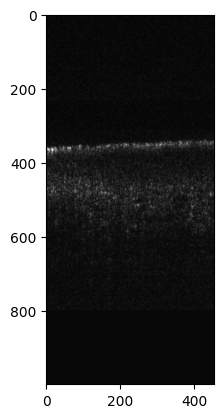

In [621]:
plt.imshow(noisy-res,cmap='gray')

In [635]:
threshold_otsu(manual_regs[250])

21

(array([3.36623e+05, 9.22380e+04, 1.86990e+04, 4.67000e+03, 1.15000e+03,
        4.15000e+02, 1.31000e+02, 4.90000e+01, 1.50000e+01, 1.00000e+01]),
 array([  0. ,  12.3,  24.6,  36.9,  49.2,  61.5,  73.8,  86.1,  98.4,
        110.7, 123. ]),
 <BarContainer object of 10 artists>)

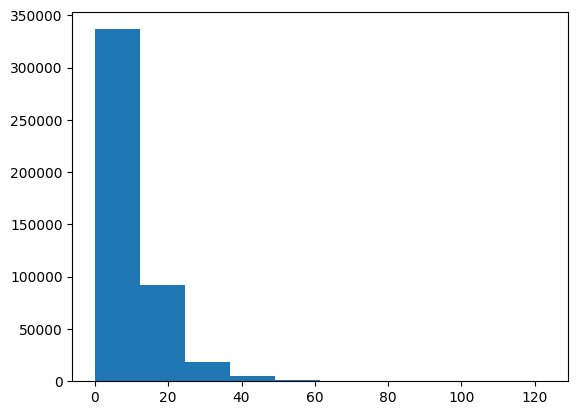

In [632]:
plt.hist(manual_regs[0].flatten())

(array([4.04493e+05, 4.20280e+04, 5.49400e+03, 1.34200e+03, 4.01000e+02,
        1.20000e+02, 7.70000e+01, 3.10000e+01, 1.10000e+01, 3.00000e+00]),
 array([  3.,  20.,  37.,  54.,  71.,  88., 105., 122., 139., 156., 173.]),
 <BarContainer object of 10 artists>)

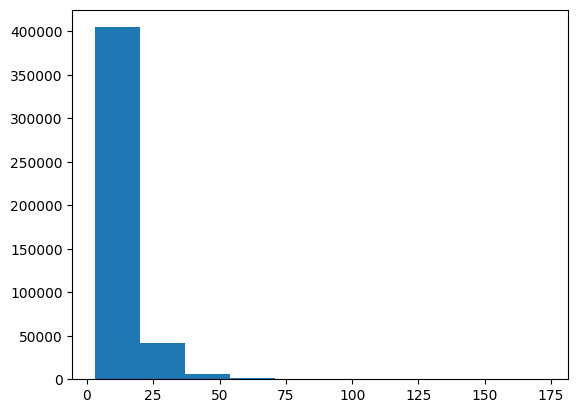

In [416]:
plt.hist((denoise*255).astype(np.uint8).flatten())

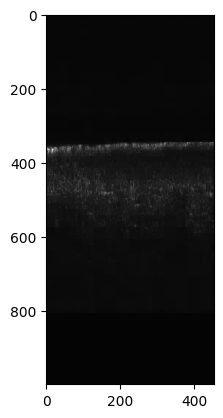

In [608]:
plt.imshow(denoise,cmap='gray',interpolation=None)
plt.imsave('ooop.png',calibrated_output)

(array([3.2090e+03, 9.6070e+03, 3.8226e+04, 1.1217e+05, 5.4188e+04,
        2.6192e+04, 4.6459e+04, 1.9778e+04, 3.1837e+04, 1.2709e+04,
        1.0910e+04, 1.7442e+04, 6.9170e+03, 1.0942e+04, 4.6290e+03,
        7.7980e+03, 3.2120e+03, 5.6940e+03, 2.4270e+03, 2.2040e+03,
        3.9490e+03, 1.6600e+03, 3.0050e+03, 1.3330e+03, 2.4060e+03,
        1.1100e+03, 1.9260e+03, 8.1400e+02, 8.2400e+02, 1.4060e+03,
        6.0900e+02, 1.0420e+03, 4.9900e+02, 8.9700e+02, 4.1800e+02,
        7.0400e+02, 3.2600e+02, 2.7400e+02, 5.0200e+02, 2.2900e+02,
        4.3200e+02, 1.7600e+02, 3.4000e+02, 1.5500e+02, 2.8200e+02,
        1.2300e+02, 1.3900e+02, 1.9800e+02, 9.4000e+01, 1.6900e+02,
        8.3000e+01, 1.4100e+02, 8.1000e+01, 1.1500e+02, 3.6000e+01,
        1.0800e+02, 4.8000e+01, 4.2000e+01, 9.2000e+01, 2.9000e+01,
        7.0000e+01, 2.3000e+01, 3.5000e+01, 2.1000e+01, 3.7000e+01,
        2.2000e+01, 2.2000e+01, 4.8000e+01, 1.6000e+01, 2.3000e+01,
        1.0000e+01, 2.6000e+01, 1.3000e+01, 2.70

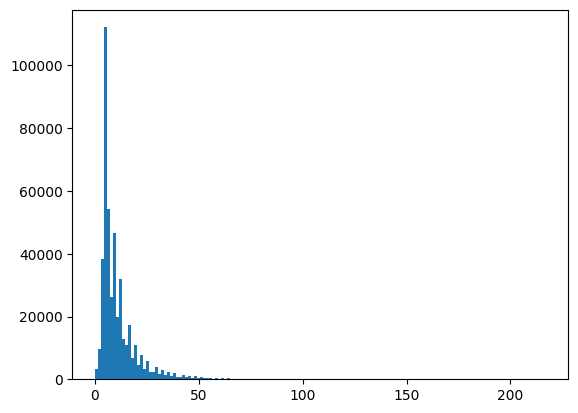

In [442]:
plt.hist(noisy.flatten(),bins=150)

In [592]:
noisy[noisy<20]=0

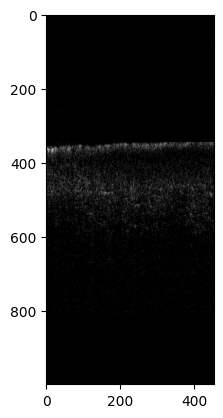

In [593]:
plt.imshow(noisy,cmap='gray',interpolation=None)
plt.imsave('ooop2.png',noisy)